In [1]:
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:

spark = SparkSession.builder.master("local[2]").appName("Linear-Regression-California-Housing").getOrCreate()

In [38]:
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)

In [39]:
housing_df = spark.read.csv("cal_housing.data",schema=schema).cache()

In [40]:
housing_df.printSchema()

root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medage: float (nullable = true)
 |-- totrooms: float (nullable = true)
 |-- totbdrms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- houshlds: float (nullable = true)
 |-- medinc: float (nullable = true)
 |-- medhv: float (nullable = true)



In [41]:
result_df = housing_df.groupBy("medage").count().sort("medage", ascending=False)


In [42]:
result_df.show(10)

+------+-----+
|medage|count|
+------+-----+
|  52.0| 1273|
|  51.0|   48|
|  50.0|  136|
|  49.0|  134|
|  48.0|  177|
|  47.0|  198|
|  46.0|  245|
|  45.0|  294|
|  44.0|  356|
|  43.0|  353|
+------+-----+
only showing top 10 rows



In [43]:
result_df1 = housing_df.groupBy('medhv').count().sort('medhv')

In [44]:
result_df1.show()

+-------+-----+
|  medhv|count|
+-------+-----+
|14999.0|    4|
|17500.0|    1|
|22500.0|    4|
|25000.0|    1|
|26600.0|    1|
|26900.0|    1|
|27500.0|    1|
|28300.0|    1|
|30000.0|    2|
|32500.0|    4|
|32900.0|    1|
|33200.0|    1|
|34200.0|    1|
|34400.0|    1|
|34600.0|    1|
|35000.0|    1|
|36600.0|    1|
|36700.0|    1|
|37500.0|    4|
|37900.0|    1|
+-------+-----+
only showing top 20 rows



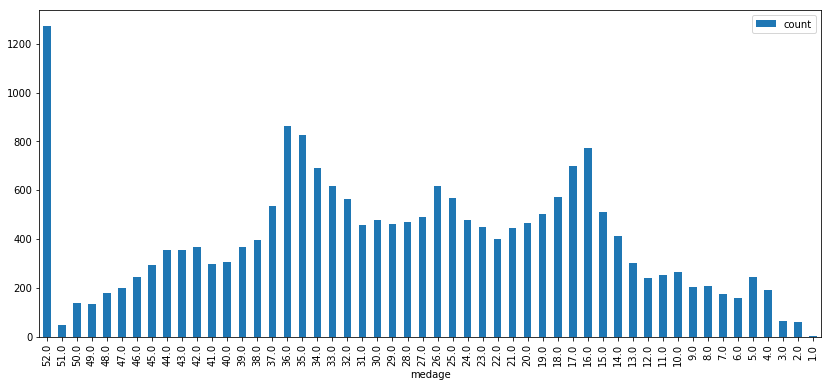

In [45]:
result_df.toPandas().plot.bar(x='medage',figsize=(14, 6))


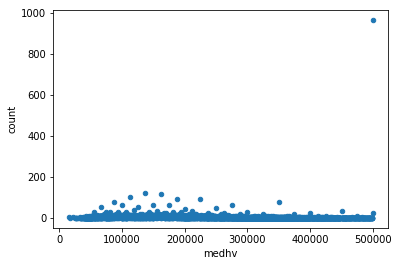

In [46]:
result_df1.toPandas().plot.scatter(x='medhv',y='count')

In [47]:
from pyspark import SparkContext
from pyspark.mllib.linalg import Vectors, Matrices
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.stat import Statistics

In [48]:
(housing_df.describe().select(
                    "summary",
                    F.round("long", 4).alias("long"),
                    F.round("lat", 4).alias("lat"),
                    F.round("medage", 4).alias("medage"),
                    F.round("totrooms", 4).alias("totrooms"),
                    F.round("totbdrms", 4).alias("totbdrms"),
                    F.round("pop", 4).alias("pop"),
                    F.round("houshlds", 4).alias("houshlds"),
                    F.round("medinc", 4).alias("medinc"),
                    F.round("medhv", 4).alias("medhv"))
                    .show())

+-------+---------+-------+-------+---------+--------+---------+--------+-------+-----------+
|summary|     long|    lat| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+---------+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|  20640.0|20640.0|20640.0|  20640.0| 20640.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|-119.5697|35.6319|28.6395|2635.7631| 537.898|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|   2.0035|  2.136|12.5856|2181.6153|421.2479|1132.4621|382.3298| 1.8998|115395.6159|
|    min|  -124.35|  32.54|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    max|  -114.31|  41.95|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+---------+-------+-------+---------+--------+---------+--------+-------+-----------+



In [49]:
housing_df = housing_df.withColumn("medhv", col("medhv")/100000)


In [50]:
housing_df.show(2)

+-------+-----+------+--------+--------+------+--------+------+-----+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|
+-------+-----+------+--------+--------+------+--------+------+-----+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|
+-------+-----+------+--------+--------+------+--------+------+-----+
only showing top 2 rows



In [51]:
housing_df = (housing_df.withColumn("rmsperhh", F.round(col("totrooms")/col("houshlds"), 2))
                       .withColumn("popperhh", F.round(col("pop")/col("houshlds"), 2))
                       .withColumn("bdrmsperrm", F.round(col("totbdrms")/col("totrooms"), 2)))

In [52]:
housing_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|    6.98|    2.56|      0.15|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|    6.24|    2.11|      0.16|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521|    8.29|     2.8|      0.13|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|3.413|    5.82|    2.55|      0.18|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|3.422|    6.28|    2.18|      0.17|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
only showing top 5 rows



In [25]:
# Re-order and select columns
housing_df=housing_df.select('long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv',
 'rmsperhh',
 'popperhh',
 'bdrmsperrm')

In [26]:
featureCols = ["long","lat","totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm"]


In [27]:
# put features into a feature vector column
assembler = VectorAssembler(inputCols=featureCols, outputCol="features") 
assembled_df = assembler.transform(housing_df)


In [54]:
from pyspark.ml.stat import Correlation


In [85]:
housing_df.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv',
 'rmsperhh',
 'popperhh',
 'bdrmsperrm']

In [59]:
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=housing_df.columns, outputCol=vector_col)
df_vector = assembler.transform(housing_df).select(vector_col)


In [80]:
matrix = Correlation.corr(df_vector, vector_col)
corr_mat= (matrix.collect()[0]["pearson({})".format(vector_col)].values)

In [81]:
corr_mat

array([ 1.00000000e+00, -9.24664430e-01, -1.08196818e-01,  4.45679828e-02,
        6.83775326e-02,  9.97732257e-02,  5.53100950e-02, -1.51758706e-02,
       -4.59666287e-02, -2.75312143e-02,  2.47403019e-03,  9.31180617e-02,
       -9.24664430e-01,  1.00000000e+00,  1.11726693e-02, -3.60995917e-02,
       -6.63183975e-02, -1.08784745e-01, -7.10354311e-02, -7.98091195e-02,
       -1.44160271e-01,  1.06379056e-01,  2.36775047e-03, -1.14431858e-01,
       -1.08196818e-01,  1.11726693e-02,  1.00000000e+00, -3.61262201e-01,
       -3.20484707e-01, -2.96244240e-01, -3.02916009e-01, -1.19033990e-01,
        1.05623412e-01, -1.53290969e-01,  1.31966359e-02,  1.35990192e-01,
        4.45679828e-02, -3.60995917e-02, -3.61262201e-01,  1.00000000e+00,
        9.29893348e-01,  8.57125973e-01,  9.18484493e-01,  1.98049644e-01,
        1.34153114e-01,  1.33795841e-01, -2.45841872e-02, -1.87273901e-01,
        6.83775326e-02, -6.63183975e-02, -3.20484707e-01,  9.29893348e-01,
        1.00000000e+00,  

In [55]:
assembled_df.show(10, truncate=False)


+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+---------------------------------------------------------------------------------------------+
|long   |lat  |medage|totrooms|totbdrms|pop   |houshlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|features                                                                                     |
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+---------------------------------------------------------------------------------------------+
|-122.23|37.88|41.0  |880.0   |129.0   |322.0 |126.0   |8.3252|4.526|6.98    |2.56    |0.15      |[-122.2300033569336,37.880001068115234,129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |
|-122.22|37.86|21.0  |7099.0  |1106.0  |2401.0|1138.0  |8.3014|3.585|6.24    |2.11    |0.16      |[-122.22000122070312,37.86000061035156,1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|
|-122.24|37.85|52.0  |1467.0  |190.

In [56]:
# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")


In [57]:
# Fit the DataFrame to the scaler
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)


In [58]:
# Inspect the result
scaled_df.select("features", "features_scaled").show(10, truncate=False)


+---------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                     |features_scaled                                                                                                                                                             |
+---------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[-122.2300033569336,37.880001068115234,129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |[-61.00727067992717,17.73447826464273,0.30623297630686513,0.2843362208866199,0.3295584480852433,4.

In [32]:
# Split the data into train and test sets
train_data, test_data = scaled_df.randomSplit([.7,.3])


In [33]:
train_data.show()

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+--------------------+--------------------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|            features|     features_scaled|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+--------------------+--------------------+
|-124.35|40.54|  52.0|  1820.0|   300.0| 806.0|   270.0|3.0147|0.946|    6.74|    2.99|      0.16|[-124.34999847412...|[-62.065399718643...|
| -124.3|41.84|  17.0|  2677.0|   531.0|1244.0|   456.0|3.0313|1.036|    5.87|    2.73|       0.2|[-124.30000305175...|[-62.040446072393...|
|-124.27|40.69|  36.0|  2349.0|   528.0|1194.0|   465.0|2.5179| 0.79|    5.05|    2.57|      0.22|[-124.26999664306...|[-62.025469315076...|
|-124.26|40.58|  52.0|  2217.0|   394.0| 907.0|   369.0|2.3571|1.114|    6.01|    2.46|      0.18|[-124.26000213623...|[-62.020480870610...|
|-124.23|40.8

In [34]:
train_data.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv',
 'rmsperhh',
 'popperhh',
 'bdrmsperrm',
 'features',
 'features_scaled']

# LINEAR REGRESSION WITH K-FOLD CROSS VALIDATION AND HYPERPARAMETER TUNING

In [212]:
# Initialize `lr`
lr = (LinearRegression(featuresCol='features_scaled', labelCol="medhv", predictionCol='predmedhv'))

In [213]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator


In [214]:
#Wtihout elastic net parameter - 1.44s
#Without regParam - 1.42se
#Without elastic net parameter and regParam - 20s

In [230]:
lrparamGrid = (ParamGridBuilder()
               .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])
               .addGrid(lr.regParam, [0.001, 0.01, 0.1, 0.5, 1.0, 2.0])
               .addGrid(lr.maxIter, [1,5,10,15])
               .build())

In [232]:
lrcv = CrossValidator(estimator = lr,
                     estimatorParamMaps= lrparamGrid,
                     evaluator=lrevaluator,
                     numFolds =5)

In [ ]:
lrevaluator = RegressionEvaluator(predictionCol= 'predmedhv',labelCol='medhv',metricName='rmse')
lr_mae_evaluator = RegressionEvaluator(predictionCol= 'predmedhv',labelCol='medhv',metricName='mae')
lr_r2_evaluator= RegressionEvaluator(predictionCol= 'predmedhv',labelCol='medhv',metricName='r2')

In [234]:
lrcvModel = lrcv.fit(train_data)

In [56]:
lrcvSummary = lrcvModel.bestModel.summary

# METRIC SUMMARY OF TRAINING DATA

In [57]:
lrcvSummary.meanAbsoluteError

0.502074118005828

In [58]:
lrcvSummary.meanSquaredError

0.4796993527277223

In [59]:
lrcvSummary.r2

0.6398453664657111

# METRIC SUMMARY OF TEST DATA

In [239]:
lr_pred = lrcvModel.transform(test_data)

In [240]:
print('RMSE:', lrevaluator.evaluate(lr_pred))

RMSE: 0.7044930073562199


In [241]:
print('MAE:', lr_mae_evaluator.evaluate(lr_pred))

MAE: 0.5040565082521727


In [242]:
print('R2:', lr_r2_evaluator.evaluate(lr_pred))

R2: 0.6288841922552169


# LINEAR REGRESSION WITHOUT CROSS VALIDATION AND PARAMETER TUNING

In [104]:
# Fit the data to the model
linearModel = lr.fit(train_data)

In [105]:
predictions = linearModel.transform(test_data)

In [106]:
predandlabels = predictions.select("predmedhv", "medhv")

In [107]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(predandlabels)))


RMSE: 0.7045908094391682


In [108]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(predandlabels)))

MAE: 0.5041169237140135


In [109]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(predandlabels)))

R2: 0.6287811439125246


# DECISION TREE REGRESSION WITHOUT CROSS VALIDATION AND PARAMETER TUNING

In [110]:
from pyspark.ml.regression import DecisionTreeRegressor


In [111]:
dt = DecisionTreeRegressor(featuresCol ='features_scaled', labelCol = 'medhv')

In [121]:
%%time
dt_model = dt.fit(train_data)

Wall time: 735 ms


In [115]:
dt_predictions = dt_model.transform(test_data)

In [116]:
new_predlab= dt_predictions.select("prediction","medhv")

In [117]:
dt_evaluator = RegressionEvaluator(predictionCol="prediction",labelCol='medhv',metricName='r2')

In [118]:
print("R2: {0}".format(dt_evaluator.evaluate(new_predlab)))

R2: 0.6124246929032348


In [119]:
dt_ma_ev = RegressionEvaluator(predictionCol="prediction", labelCol='medhv', metricName='mae')
print("MAE: {0}".format(dt_ma_ev.evaluate(new_predlab)))

MAE: 0.524869174620771


In [120]:
dt_ms_ev = RegressionEvaluator(predictionCol="prediction", labelCol='medhv', metricName='rmse')
print("RMSE: {0}".format(dt_ms_ev.evaluate(new_predlab)))


RMSE: 0.7199461437984649


# DECISION TREE WITH CROSS VALIDATION AND PARAMETER TUNING

In [243]:
dtparamGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2, 5, 10, 20, 30])
             #.addGrid(dt.maxDepth, [2, 5, 10])
             .addGrid(dt.maxBins, [10, 20, 40, 80, 100])
             #.addGrid(dt.maxBins, [10, 20])
             .build())


In [244]:
#Wihtout MaxBins- 2.14 minutes-- r2-0.69,mae-0.529,rmse-0.728
#Without MaxDepth--41 seconds--r2--0.603,mae--0.5293,rmse--0.72
#Combination of both of them--r2-0.70,mae-0.42,rmse-0.63
#BINS-- number of bins used for splitting
#DEPTH-- How many leaf node and internal node are implemented

In [245]:
dtevaluator = RegressionEvaluator(predictionCol="prediction", labelCol="medhv",metricName="rmse")
dt_mae_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="medhv", metricName="mae")
dt_r2_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="medhv", metricName="r2")


In [246]:
dtcv = CrossValidator(estimator = dt,
                      estimatorParamMaps = dtparamGrid,
                      evaluator = dtevaluator,
                      numFolds = 5)

In [247]:
dtcvModel = dtcv.fit(train_data)

Wall time: 11min 53s


In [47]:
dtpredictions = dtcvModel.transform(test_data)

# DECISION TREE METRICS OF TEST DATA

In [48]:
print("R2: {0}".format(dt_r2_evaluator.evaluate(dtpredictions)))

R2: 0.6948624308016813


In [40]:
print("MAE: {0}".format(dt_mae_evaluator.evaluate(dtpredictions)))

MAE: 0.5293432024976972


In [41]:
print("RMSE: {0}".format(dtevaluator.evaluate(dtpredictions)))


RMSE: 0.7285256081917704


# GRADIENT BOOSTED TREE REGRESSION WITHOUT CROSS VALIDATION AND PARAMETER TUNING

In [248]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features_scaled', labelCol = 'medhv')

In [132]:
gbt_model = gbt.fit(train_data)

Wall time: 7.73 s


In [124]:
gbt_predictions = gbt_model.transform(test_data)

In [125]:
new_gbt = gbt_predictions.select('prediction','medhv')

In [126]:
gbt_evaluator_r2 = RegressionEvaluator(labelCol = "medhv",predictionCol="prediction",metricName='r2')

In [127]:
print("R2: {0}".format(gbt_evaluator_r2.evaluate(gbt_predictions)))

R2: 0.7523300960077743


In [128]:
gbt_eval_ma = RegressionEvaluator(predictionCol="prediction", labelCol='medhv', metricName='mae')

In [129]:
print("MAE: {0}".format(gbt_eval_ma.evaluate(gbt_predictions)))

MAE: 0.393843129177601


In [130]:
gbt_eval = RegressionEvaluator(predictionCol="prediction", labelCol='medhv')


In [131]:
print("RMSE: {0}".format(gbt_eval.evaluate(gbt_predictions)))


RMSE: 0.5755175581973053


# GRADIENT BOOSTED TREE REGRESSION WITH CROSS VALIDATION AND PARAMETER TUNING

In [249]:
gbt_eval_ma = RegressionEvaluator(predictionCol="prediction", labelCol='medhv', metricName='mae')
gbt_evaluator_r2 = RegressionEvaluator(labelCol = "medhv",predictionCol="prediction",metricName='r2')
gbt_eval = RegressionEvaluator(predictionCol="prediction", labelCol='medhv')


In [250]:
gbparamGrid = (ParamGridBuilder()
             #.addGrid(rf.maxDepth, [2, 5, 10, 20, 30])
               .addGrid(gbt.maxDepth, [2, 5, 10])
               .addGrid(rf.maxBins, [10, 20, 40])
             .build())

In [251]:
gbcv = CrossValidator(estimator = gbt,
                      estimatorParamMaps = gbparamGrid,
                      evaluator = gbt_eval,
                      numFolds = 5)


In [252]:
%%time
gbcv_model = gbcv.fit(train_data)

Wall time: 19h 3min 48s


In [172]:
gbcv_predictions = gbcv_model.transform(test_data)

In [173]:
print("R2: {0}".format(gbt_evaluator_r2.evaluate(gbcv_predictions)))

R2: 0.7523300960077743


In [174]:
print("RMSE: {0}".format(gbt_eval.evaluate(gbcv_predictions)))


RMSE: 0.5755175581973053


In [175]:
print("MAE: {0}".format(gbt_eval_ma.evaluate(gbcv_predictions)))

MAE: 0.393843129177601


# RANDOM FOREST REGRESSION WITHOUT CROSS VALIDATION AND PARAMETER TUNING

In [133]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol = 'features_scaled', labelCol = 'medhv')

In [143]:
rf_model = rf.fit(train_data)

Wall time: 1.05 s


In [135]:
rf_predictions = rf_model.transform(test_data)

In [136]:
rf_dataset = rf_predictions.select('prediction','medhv')

In [137]:
rf_evaluator = RegressionEvaluator(labelCol = "medhv",predictionCol="prediction",metricName='r2')

In [138]:
print("R2: {0}".format(rf_evaluator.evaluate(rf_dataset)))

R2: 0.6275681903386595


In [139]:
ef_eval_ma = RegressionEvaluator(predictionCol="prediction", labelCol='medhv', metricName='mae')

In [140]:
print("MAE: {0}".format(ef_eval_ma.evaluate(rf_dataset)))

MAE: 0.5266951829568756


In [141]:
rf_eval_ms = RegressionEvaluator(predictionCol="prediction", labelCol='medhv', metricName='rmse')

In [142]:
print("RMSE: {0}".format(rf_eval_ms.evaluate(rf_dataset)))


RMSE: 0.7057409920554986


# RANDOM FOREST REGRESSION WITH CROSS VALIDATION

In [176]:
rfevaluator = RegressionEvaluator(predictionCol="prediction", labelCol="medhv", metricName="rmse")
rf_mae_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="medhv", metricName="mae")
rf_r2_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="medhv", metricName="r2")


In [184]:
rfparamGrid = (ParamGridBuilder()
             #.addGrid(rf.maxDepth, [2, 5, 10, 20, 30])
               .addGrid(rf.maxDepth, [2, 5, 10])
             #.addGrid(rf.maxBins, [10, 20, 40, 80, 100])
               .addGrid(rf.maxBins, [5, 10, 20])
             #.addGrid(rf.numTrees, [5, 20, 50, 100, 500])
               #.addGrid(rf.numTrees, [5, 20, 50])
             .build())

In [185]:
rfcv = CrossValidator(estimator = rf,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = rfevaluator,
                      numFolds = 5)


In [191]:
%%time
rfcv_model = rfcv.fit(train_data)

Wall time: 2min 22s


In [187]:
rfcvpredictions = rfcv_model.transform(test_data)

In [188]:
print("R2: {0}".format(rf_r2_evaluator.evaluate(rfcvpredictions)))

R2: 0.7440082345380256


In [189]:
print("MAE: {0}".format(rf_mae_evaluator.evaluate(rfcvpredictions)))

MAE: 0.4123336729817173


In [190]:
print("RMSE: {0}".format(rfevaluator.evaluate(rfcvpredictions)))


RMSE: 0.5851065470915312
